In [1]:
from collections import defaultdict
from datetime import datetime
import math
from operator import itemgetter
import os
import random
import re

import numpy as np
import pandas as pd

%matplotlib inline

import little_mallet_wrapper as lmw

<br><br>

# MALLET Path

Change the path below to the location of your local MALLET installation.

In [2]:
path_to_mallet = '/Volumes/Passport-1/packages/mallet-2.0.8/bin/mallet'  # CHANGE THIS TO YOUR MALLET PATH

<br><br>

# Load poetry dataset

Data is available here:  
https://www.kaggle.com/johnhallman/complete-poetryfoundationorg-dataset

In [3]:
poetry_path = '/Volumes/Passport-1/data/kaggle-poem-dataset/kaggle_poem_dataset.csv'  # CHANGE THIS TO YOUR DATASET PATH

In [14]:
poetry_df = pd.read_csv(poetry_path)
poetry_df.sample(5)

,Unnamed: 0,Author,Title,Poetry Foundation ID,Content
2994,2994,Michael Miller,December,57920,I want to be a passenger\nin your car again\na...
7054,7054,William Carlos Williams,Kora in Hell: Improvisations XXII,54565,XXII\n\n1\n\nThis is a slight stiff dance to a...
14385,14385,Hoa Nguyen,Unused Baby,56858,Unused baby blood and this is\nhow you motion ...
11644,11644,Derek Walcott,The Schooner\n \n Flight,48316,"1\nAdios, Carenage\n\nIn idle August, while th..."
5374,5374,Adrian Matejka,“Gymnopédies No. 3”,56678,This sunlight on snow.\n\nThis decrescendo\nof...


In [15]:
print(len(poetry_df.index))

15652


In [16]:
training_data = [lmw.process_string(t) for t in poetry_df['Content'].tolist()]
training_data = [d for d in training_data if d.strip()]

len(training_data)

15644

In [17]:
training_data[10]

'heart let pity let live sad self hereafter kind charitable live tormented mind tormented mind tormenting yet cast comfort get groping round comfortless blind eyes dark day thirst find thirst world wet soul self come poor jackself advise jaded let call thoughts awhile elsewhere leave comfort root room let joy size god knows god knows whose smile wrung see unforeseen times rather skies betweenpie mountains lights lovely mile'

In [18]:
authors = poetry_df['Author'].tolist()

len(authors)

15652

In [19]:
lmw.print_dataset_stats(training_data)

Number of Documents: 15644
Mean Number of Words per Document: 136.9
Vocabulary Size: 103060


<br><br>

# Train topic model

Depending on the size of your dataset, training can take a while. For very large datasets, I recommending training outside of a notebook.

If you're training in a Jupyter notebook, you can observe progress by checking the terminal window from which you started Jupyter. The MALLET output will also be printed at the end of training.

Note that training creates a copy of your dataset, so it might require significant space.

## Training Option A: Get started quickly!

Use this function if you want to quickly load the topic keys and distributions, without fine control over the training parameters and output paths.

In [20]:
num_topics = 20  # CHANGE THIS TO YOUR PREFERRED NUMBER OF TOPICS

output_directory_path = '/Users/maria/Desktop/lmw-output' # CHANGE THIS TO YOUR OUTPUT DIRECTORY

In [21]:
topic_keys, topic_distributions = lmw.quick_train_topic_model(path_to_mallet, 
                                                              output_directory_path, 
                                                              num_topics, 
                                                              training_data)

Importing data...
Complete
Training topic model...
Complete


In [22]:
assert(len(topic_distributions) == len(training_data))

In [23]:
for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t[:10]))

0 	 song way music dance gives sing que sang play sound
1 	 upon yet far round sea like many deep ever whose
2 	 said could one would came saw went knew took father
3 	 NUM þat hym ful watz hit alle þay hem bot
4 	 thy thou thee love shall fair yet hath doth sweet
5 	 like say get know want one good think says got
6 	 water sea river sand like ocean stone land fish rock
7 	 NUM black america new white people american war name poem
8 	 þæt ond wæs swa þær æfter mid ofer wið hie
9 	 tree green leaves flowers trees garden grass flower yellow red
10 	 love god death life let heart man dead men soul
11 	 come dat die rejoice beatrice raggedy dey miss walter troy
12 	 like hands black eyes body white hair back face head
13 	 man old horse men king great one two thousand war
14 	 may yet still good well must great give whose though
15 	 city street house door room one window back two new
16 	 one like know would time nothing even way world could
17 	 like night light sky wind sun dark white a

In [24]:
for p, d in lmw.get_top_docs(training_data, topic_distributions, topic_index=0, n=3):
    print(round(p, 4), d)
    print()

0.7127 play egg play triangle play reed play angle play lyre play lute play snare play flute play licorice stick play juke play kettle play uke ever thought triangle ever thought clarinet castanets cornet discotheque harmonium euphonium marimbas maracas harmonicas tom toms tatas play fiddle play jug play washboard washtub play kalimba play koto play organ play banjo play fool play cool play hot play pranks played mixtape forgot say thanks

0.6567 heureux ceux qui ont clim corse matin NUM NUM NUM heureux ceux qui ont clim pendant grande canicule heureux whose culs cool heureuse heureux est canicule qui hurle ready tear limb limb heureux ceux qui ont clim cri criant turlútuturle situation est grim mise scène trifle burle chaleur disons donc gueule keep amused slim heureux qui par terre roule lucky luke lucky jim edith piaf tiger tim plus divin poupoule heureux toccate heureux hymne heureux mouvements perpetuels heureuses les bîches immortelles tristesse sexuelle synonyme regrette rien fu

## Training Option B: Train using import and training functions

Use these functions to have more control over the training parameters and output paths.

In [25]:
num_topics = 20  # CHANGE THIS TO YOUR PREFERRED NUMBER OF TOPICS

output_directory_path = '/Users/maria/Desktop/lmw-output' # CHANGE THIS TO YOUR OUTPUT DIRECTORY

path_to_training_data           = output_directory_path + '/training.txt'
path_to_formatted_training_data = output_directory_path + '/mallet.training'
path_to_model                   = output_directory_path + '/mallet.model.' + str(num_topics)
path_to_topic_keys              = output_directory_path + '/mallet.topic_keys.' + str(num_topics)
path_to_topic_distributions     = output_directory_path + '/mallet.topic_distributions.' + str(num_topics)
path_to_word_weights            = output_directory_path + '/mallet.word_weights.' + str(num_topics)
path_to_diagnostics             = output_directory_path + '/mallet.diagnostics.' + str(num_topics) + '.xml'

In [27]:
lmw.import_data(path_to_mallet,
                path_to_training_data,
                path_to_formatted_training_data,
                training_data)

Importing data...
Complete


In [28]:
lmw.train_topic_model(path_to_mallet,
                      path_to_formatted_training_data,
                      path_to_model,
                      path_to_topic_keys,
                      path_to_topic_distributions,
                      path_to_word_weights,
                      path_to_diagnostics,
                      num_topics)

Training topic model...
Complete


In [29]:
topic_keys = lmw.load_topic_keys(output_directory_path + '/mallet.topic_keys.' + str(num_topics))

for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t[:10]))

0 	 NUM street city new back home two car house one
1 	 said could would came one saw went knew took mother
2 	 america american people problem new NUM war president state united
3 	 thy love thou shall thee heart yet life soul sweet
4 	 NUM poem poetry poems book poet writing words read wrote
5 	 one like know say would time way never see think
6 	 NUM þat hym ful watz hit alle þay hem bot
7 	 sea water river ocean waves shore fish sand ship boat
8 	 one world light life time mind body even like nothing
9 	 black got let john ain man come good dance gone
10 	 may yet man well still must good nature much best
11 	 thir heav thou thy thee thus god though earth shall
12 	 que duke les witch qui beads des mon dong est
13 	 like light night wind sun sky green white dark air
14 	 god men death man dead world blood earth old let
15 	 like eyes face man body woman mother hands hair white
16 	 eat pink tea bread kitchen table milk coffee chicken wine
17 	 þæt ond wæs swa þær æfter mid ofer wið

In [30]:
topic_distributions = lmw.load_topic_distributions(output_directory_path + '/mallet.topic_distributions.' + str(num_topics))

len(topic_distributions), len(topic_distributions[0])

(15644, 20)

In [31]:
assert(len(topic_distributions) == len(training_data))

In [32]:
for p, d in lmw.get_top_docs(training_data, topic_distributions, topic_index=0, n=3):
    print(round(p, 4), d)
    print()

0.6501 NUM imagine big room women anything playing cards meeting rattle paper coffee cups chairs pushed back loud quiet murmur voices women leaning heads together leaned door said women mothers

0.6435 john kennedy new york city saw across lobby flight NUM louis albuquerque coyote looked control cool fitting right city smiling pretty woman passed figuring flight making calculations behind new york times slick right tony lamas coyote recognize anywhere copenhagen new york gallup people say dress coyote always coyote

0.6417 smuggle crates beaujolais squeaky pantry door steal cases cigarettes borrow bulletproof mercedes race capital empty streets wonderful peace local afford car except police police stand beside cars wave police lack petrol cars beer bottle shortage nation bars drunk driving hobby driving high art one bad girls group back mercedes vijay ashanti drum way beach money worthless cigarettes money thirteen rent hut roofed palm fronds lie sand bottles french wine hong kong blon

In [34]:
topic_word_probability_dict = lmw.load_topic_word_distributions(output_directory_path + '/mallet.word_weights.' + str(num_topics))

len(topic_word_probability_dict)

20

In [41]:
for _topic, _word_probability_dict in topic_word_probability_dict.items():
    print('Topic', _topic)
    for _word, _probability in sorted(_word_probability_dict.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(round(_probability, 4), '\t', _word)
    print()

Topic 0
0.0082 	 NUM
0.0074 	 street
0.0067 	 city
0.0062 	 new
0.0058 	 back

Topic 1
0.0242 	 said
0.0161 	 could
0.0139 	 would
0.0138 	 came
0.0129 	 one

Topic 2
0.0084 	 america
0.0075 	 american
0.0071 	 people
0.0037 	 problem
0.0037 	 new

Topic 3
0.0194 	 thy
0.0162 	 love
0.015 	 thou
0.0108 	 shall
0.0108 	 thee

Topic 4
0.143 	 NUM
0.0151 	 poem
0.0111 	 poetry
0.0089 	 poems
0.0088 	 book

Topic 5
0.0183 	 one
0.0166 	 like
0.0147 	 know
0.0133 	 say
0.0106 	 would

Topic 6
0.0348 	 NUM
0.0267 	 þat
0.0093 	 hym
0.008 	 ful
0.0072 	 watz

Topic 7
0.0436 	 sea
0.0232 	 water
0.0133 	 river
0.0099 	 ocean
0.0096 	 waves

Topic 8
0.0114 	 one
0.0075 	 world
0.0063 	 light
0.0062 	 life
0.0062 	 time

Topic 9
0.014 	 black
0.0134 	 got
0.0068 	 let
0.0066 	 john
0.0065 	 ain

Topic 10
0.0092 	 may
0.0072 	 yet
0.0067 	 man
0.0063 	 well
0.0051 	 still

Topic 11
0.0147 	 thir
0.0138 	 heav
0.0133 	 thou
0.0119 	 thy
0.0107 	 thee

Topic 12
0.0049 	 que
0.0037 	 duke
0.0034 	 l

In [39]:
lmw.get_js_divergence_topics(0, 7, topic_word_probability_dict)

0.7658978623589292

<br><br>

# Plot topics by category

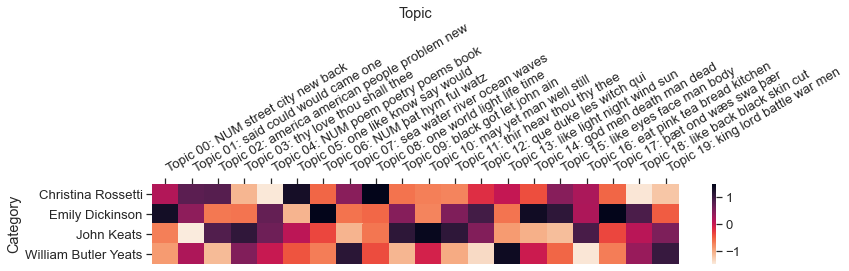

In [42]:
target_labels = ['John Keats', 'Emily Dickinson', 'William Butler Yeats', 'Christina Rossetti']

lmw.plot_categories_by_topics_heatmap(authors,
                                      topic_distributions,
                                      topic_keys, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim=(12,4))

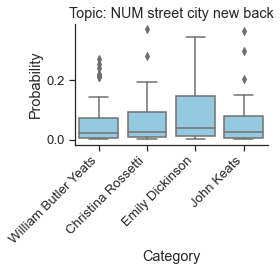

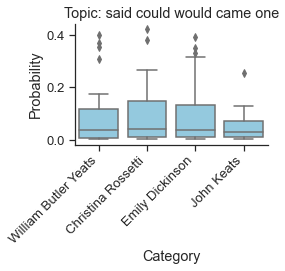

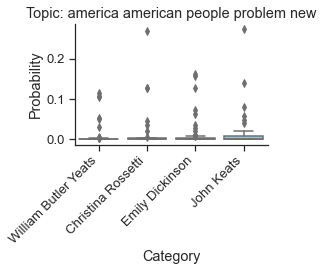

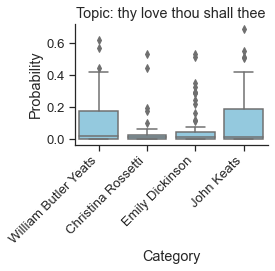

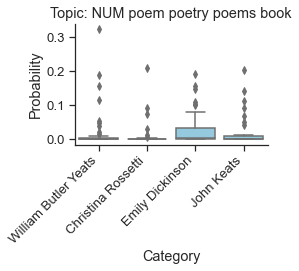

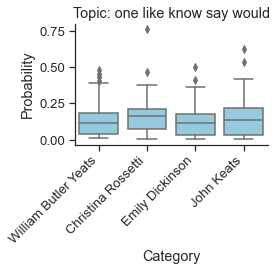

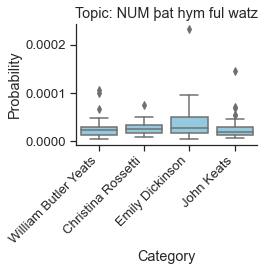

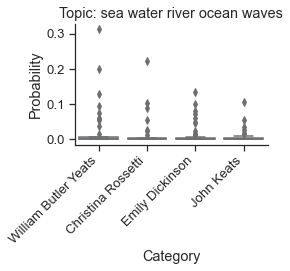

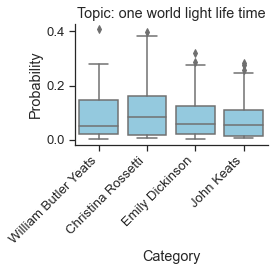

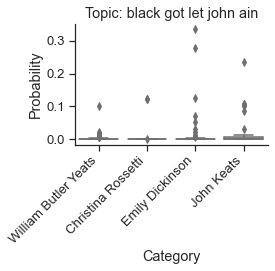

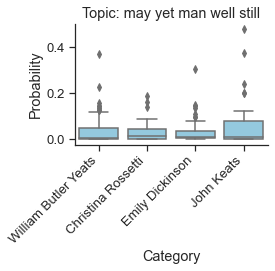

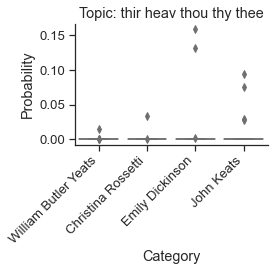

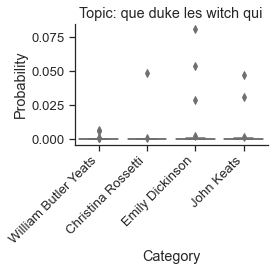

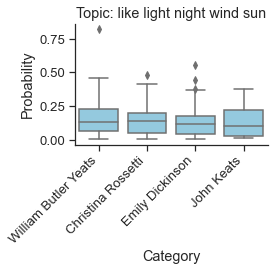

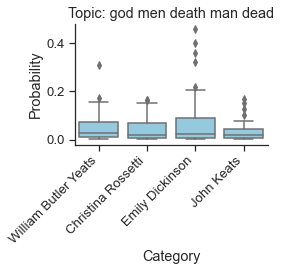

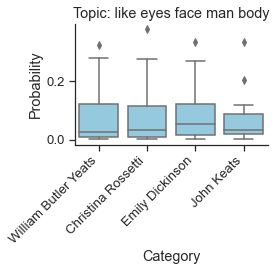

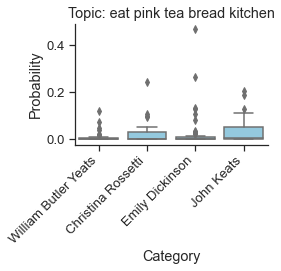

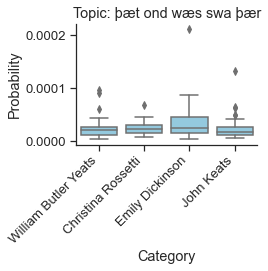

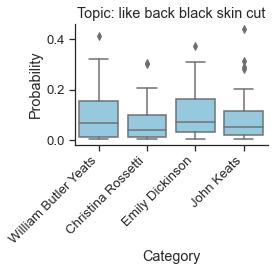

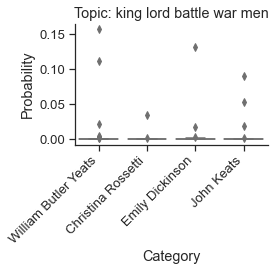

In [43]:
target_labels = ['John Keats', 'Emily Dickinson', 'William Butler Yeats', 'Christina Rossetti']

for _topic_index in range(0, len(topic_keys)):
    
    lmw.plot_categories_by_topic_boxplots(authors,
                                          topic_distributions,
                                          topic_keys, 
                                          _topic_index,
                                          output_path=output_directory_path + '/boxplot.' + str(_topic_index) + '.pdf',
                                          target_labels=target_labels,
                                          dim=(4,4))

<br><br>

# Plot topics over document time

Splits each training document into N chunks, infers the topics for those chunks (using the pre-trained topic model), and plots mean topic probabilities over document time.

In the example shown, it looks like poems often start with physical descriptions and end with abstract and romantic language.

In [44]:
divided_documents, document_ids, times = lmw.divide_training_data(training_data,
                                                                  num_chunks=10)

len(divided_documents), len(document_ids), len(times)

(156440, 156440, 156440)

In [45]:
path_to_divided_training_data           = output_directory_path + '/training.split.txt'
path_to_divided_formatted_training_data = output_directory_path + '/mallet.split.training'
path_to_divided_topic_distributions     = output_directory_path + '/mallet.split.topic_distributions.' + str(num_topics)

In [46]:
lmw.import_data(path_to_mallet,
                path_to_divided_training_data,
                path_to_divided_formatted_training_data,
                divided_documents,
                use_pipe_from=path_to_formatted_training_data)

Importing data using pipe...
Complete


In [47]:
lmw.infer_topics(path_to_mallet,
                 path_to_model,
                 path_to_divided_formatted_training_data,
                 path_to_divided_topic_distributions)

Inferring topics using pre-trained model...
Complete


In [48]:
topic_distributions = lmw.load_topic_distributions(path_to_divided_topic_distributions)

len(topic_distributions), len(topic_distributions[2])

(156440, 20)

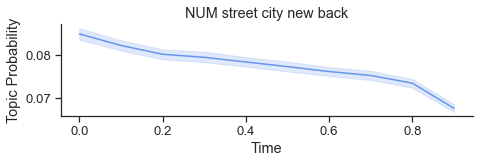

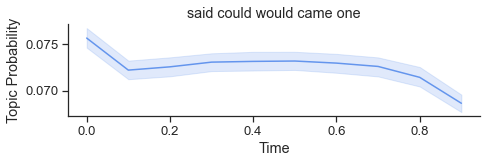

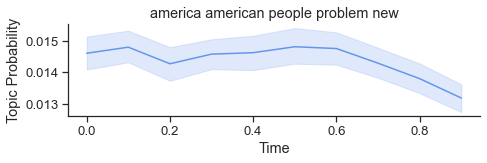

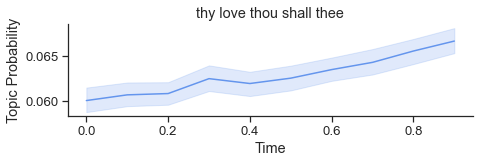

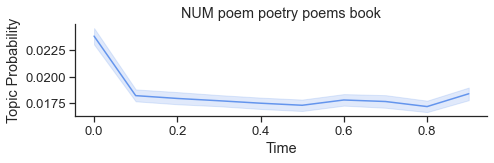

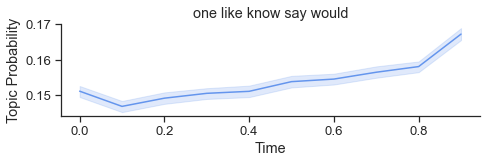

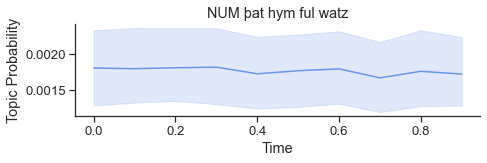

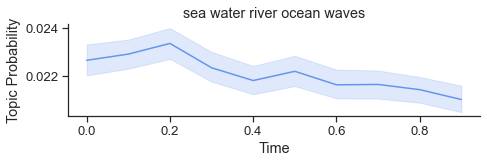

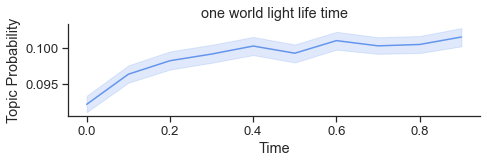

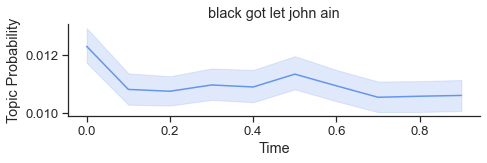

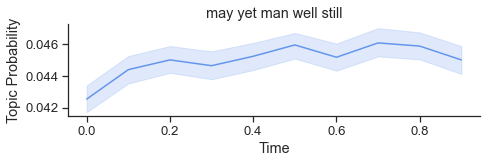

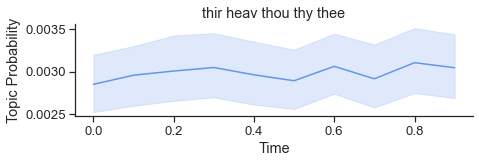

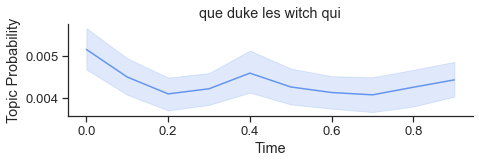

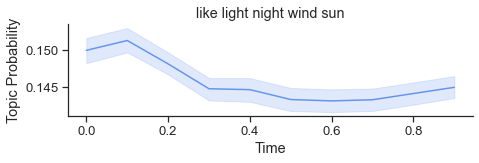

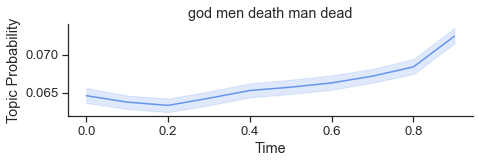

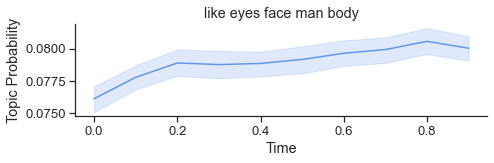

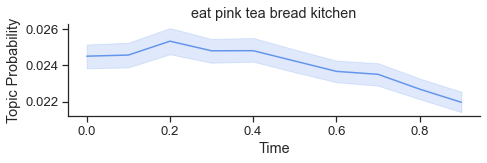

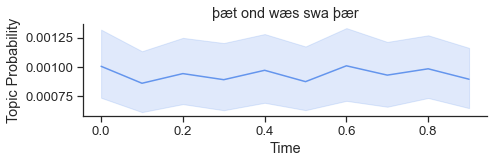

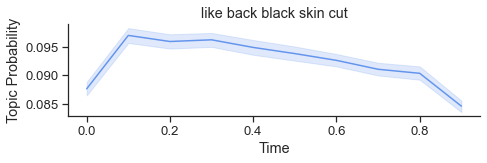

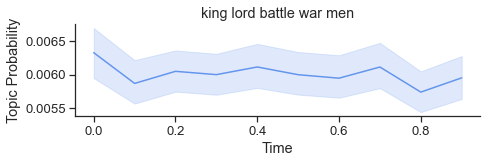

In [49]:
for _topic_index in range(0, len(topic_keys)):
    lmw.plot_topics_over_time(topic_distributions, topic_keys, times, _topic_index)